### Giới thiệu
Trong bài học này mình sẽ lồng ghép 2 patterns rất phổ biến là DI (Dependency Injection) và Factory. Mình sẽ dùng phương pháp đưa ra nhu cầu thực tiễn từ đó sẽ triển khai code theo nhu cầu này. Ở mỗi bước mình sẽ thay đổi code cho phù hợp và giải thích lý do tại sao lại thay đổi. Các bạn chỉ cần follow theo đúng luồng từ trên xuống dưới thì các bạn sẽ dần dần sáng tỏ được tại sao phải sử dụng những patterns này

### Yêu cầu
Giả sử yêu cầu của hệ thống cần sử dụng 2 loại cache là Redis và Memcached, và nếu chuyển đổi qua lại 2 loại cache này thì không ảnh hưởng trực tiếp đến tầng code bên trên (tầng ứng dụng)

### Phân tích
Từ yêu cầu bên trên ta có thể thấy chúng ta cần thiết kế 1 thành phần chung để code lớp trên sử dụng mà không ảnh hưởng trực tiếp đến code của 2 loại cache này, nhưng có vẻ hơi rắc rối vì rõ ràng hàm set cache thì 2 loại cache này đều khác nhau, Redis thì dùng redis_set, Memcached thì dùng memcached_set. Cách giải quyết cho bài toán này là DI pattern, với pattern này nó sẽ tách 2 thành phần code của 2 tầng riêng biệt, tầng Servce sẽ tương tác trực tiếp với tầng ứng dụng, và tầng Client sẽ tương tác trực tiếp với các Cache library.

Riêng với tầng client chúng ta có thể thiết kế để nó có thể tương tác đến nhiều loại Cache library khác nhau.

### Bắt đầu
Để bắt đầu chúng ta hãy thử sử dụng các thư viện cache từ mock
Trong ví dụ này mình có cung cấp cho bạn thư mục moke để mô phỏng lại 2 loại cache Redis và Memcached, và code khởi tạo cũng như code thực hiện của chúng cũng khác nhau

In [1]:
from moke import Redis, Memcached

redis = Redis(port=6379, host='localhost', db=0)
redis.redis_set("username", "john_doe")
username = redis.redis_get("username")
print(username)

john_doe


Tiếp theo mình sẽ viết lớp Client cho 2 loại Cache này

In [2]:
from moke import Redis, Memcached


class RedisClient():
    def __init__(
        self,
         port, host, db
    ):
        self.redis = Redis(port, host, db)

    def _set(self, key, value):
        self.redis.redis_set(key, value)

    def _get(self, key):
        return self.redis.redis_get(key)

class MemcachedClient():
    def __init__(
        self,
         port, host
    ):
        self.memcached = Memcached(port, host)

    def _set(self, key, value):
        self.memcached.memcached_set(key, value)

    def _get(self, key):
        return self.memcached.memcached_get(key)

Điểm chung của 2 class bên trên là có các method giống nhau (_set, _get) để lớp Service có thể gọi vào method này để tiếp cận đến Client

Bước tiếp mình sẽ tạo ra class Service tương tác với tầng ứng dụng

In [3]:
class CacheService():
    def __init__(
        self,
         client
    ):
        self.client = client
    
    def set(self, key, value):
        self.client._set(key, value)

    def get(self, key):
        return self.client._get(key)

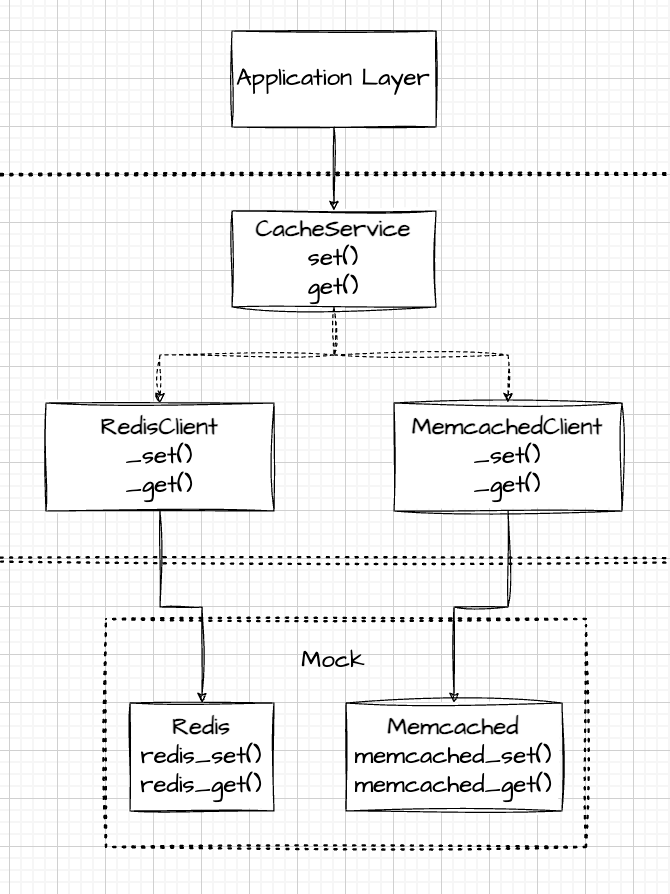

OK, đến bước này chúng ta cần test thử các lớp đã tạo để có cái nhìn trực quan hơn

In [4]:
redis_client = RedisClient(host='localhost', port=6379, db=0)
memcached_client = MemcachedClient(host='localhost', port=11211)

cache = CacheService(client=redis_client)
cache.set("username", "john_doe")

username = cache.get("username")
print(username)

john_doe


Bên trên in ra thử key username kết quả john_doe là hoàn toàn chính xác
Tiếp tục bên dưới ta đổi Cache client sang memcached_client để xem kết quả thế nào

In [5]:
cache = CacheService(client=memcached_client)
username = cache.get("username")
print(username)

None


Kết qủa chắc chắn in ra None, vì không có key username trong Memcached

Ở bước này bạn đã thấy rõ được tầng ứng dụng tách biệt với tầng client, ta có thể dễ dàng switch qua lại 2 client này mà không hề ảnh hưởng đến tầng ứng dụng

Khi hiểu được bản chất của DI pattern thì bạn sẽ dễ dàng đọc hiểu các ví dụ tìm được trên mạng, nó có thể thêm thắt ở tầng ứng dụng để làm rõ ứng dụng của ví dụ đó, cũng có thể có ví dụ chỉ có duy nhất 1 client, với những ví dụ này có thể sẽ làm bạn hơi lúng túng, nhưng bạn chỉ cần nắm được bản chất của DI là chỉ cần 2 lớp là Service và Client.

### Tối ưu
Trong code trên vẫn còn một vài vấn đề chưa hoàn toàn gọi là hoàn chỉnh, nếu xét về khía cạnh của người thiết kế patterns

Giả sử sau này có 1 yêu cầu thêm 1 Cache client khác và lúc này bạn không còn phụ trách ở phần việc này, nên sẽ có 1 team member khác làm tiếp công việc này, với khối lượng code khổng lồ trong project của bạn sẽ khó khăn cho member này khi thêm 1 client mới, để rõ hơn bạn hãy nhìn vào code bên dưới
```python
class RedisClient():
    def __init__(
        self,
         port, host, db
    ):
        self.redis = Redis(port, host, db)

    def _set(self, key, value):
        self.redis.redis_set(key, value)

    def _get(self, key):
        return self.redis.redis_get(key)
```
Member mới này sẽ cố gắng tham khảo class RedisClient và liệt kê những method hiện tại _set, _get, đây là trường hợp class này quá ít method còn nếu vài chục đến cả trăm method thì thế nào, chúng ta cũng chỉ là con người chắc chắn sẽ có sai sót. Vậy bạn có ý tưởng nào để giải quyết trường hợp này không?

Để giải quyết tình huống này với python chúng ta sẽ tạo 1 class Base và dùng abstractmethod để lớp con phải định nghĩa lại method này, nếu không sẽ bị cảnh báo lỗi. Các bạn yên tâm rằng với các ngôn ngữ khác đều có cách giải quyết tương tự.

In [6]:
from abc import ABC, abstractmethod

class ClientCacheBase(ABC):
    """Interface for Cache clients."""
    @abstractmethod
    def _set(self, key, value):
        """Caching Set: function used to set cache"""
    @abstractmethod
    def _get(self, key):
        """Caching Get: function used to get cache"""

Với abstractmethod thì class kế thừa class này phải tuân thủ đúng với các methods được định nghĩa, vậy ta cần sửa lại một chút về code trước đó

In [7]:
class RedisClient(ClientCacheBase):
    def __init__(
        self,
         port, host, db
    ):
        self.redis = Redis(port, host, db)

    def _set(self, key, value):
        self.redis.redis_set(key, value)

    def _get(self, key):
        return self.redis.redis_get(key)

class MemcachedClient(ClientCacheBase):
    def __init__(
        self,
         port, host
    ):
        self.memcached = Memcached(port, host)

    def _set(self, key, value):
        self.memcached.memcached_set(key, value)

    def _get(self, key):
        return self.memcached.memcached_get(key)

Và bạn cũng cần phải update lại class CacheService, biến client phải có kiểu dữ liệu là ClientCacheBase, điều này đảm bảo được khi team member của bạn đang code hoặc update feature liên quan đến phần code này sẽ nhận được suggestions, ví dụ như trong hàm set bên dưới nếu bạn gõ self.client đến dấu chấm tiếp theo thì suggestion sẽ list những attributes liên quan hiển thị lên trình soạn thảo code

In [8]:
class CacheService():
    def __init__(
        self,
         client: ClientCacheBase
    ):
        self.client = client
    
    def set(self, key, value):
        self.client._set(key, value)

    def get(self, key):
        return self.client._get(key)

```python
redis_client = RedisClient(host='localhost', port=6379, db=0)
cache = CacheService(client=redis_client)
```
Code trước đó class RedisClient được tạo ra để cung cấp cho class CacheService, nhưng hiện tại có một yêu cầu nâng cao là cần giấu logic code tạo Cache Service, vậy là sao để không xuất hiện 2 class này ở tầng ứng dụng

Câu trả lời đó là bạn phải dùng Factory pattern, để tạo Factory pattern thì ta cần tạo 1 class đại diện cho Factory sẽ tương tác với tầng ứng dụng và những class tương tác trực tiếp đến tầng thấp hơn (Clients), trong đó class Clients đã được tạo trước đó bằng DI pattern là RedisClient và MemcachedClient. Ở bước này các bạn sẽ thấy rõ được sự kết hợp giữa DI pattern và Factory pattern. Vậy đầu tiên tôi cần tạo class Factory:

In [9]:
from enum import Enum

class CacheType(Enum):
    REDIS = 0
    MEMCACHED = 1

class CacheFactory:
    def getClient(self, cache_type: CacheType):
        if cache_type == CacheType.REDIS:
            redis_client = RedisClient(host="localhost", port=6379, db=0)
            return CacheService(client=redis_client)
        elif cache_type == CacheType.MEMCACHED:
            memcached_client = MemcachedClient(host="localhost", port=11211)
            return CacheService(client=memcached_client)

Cuối cùng ở tầng ứng dụng hãy viết code triển khai các patterns mà mình đã kết hợp bên trên để thành một ứng dụng hoàn chỉnh

In [10]:
cache_provider = CacheFactory()
redis = cache_provider.getClient(CacheType.REDIS)
memcached = cache_provider.getClient(CacheType.MEMCACHED)
redis.set("username", "john_doe")
username = redis.get("username")
print(username)
memcached.set("username", "john_doe2")
username = memcached.get("username")
print(username)

john_doe
john_doe2


Nếu bạn đã đọc bài viết về [Factory pattern](https://github.com/Design-Patterns-Tutorials/factory-and-abstract-factory-in-examples "Factory pattern") trước đó bạn sẽ hiểu lý do tại sao nên chọn Factory pattern, nhưng có vẻ như cả 2 bài viết đều tương tự nhau về ví dụ, vậy điểm khác nhau của chúng là gì?

Ở cả 2 bài viết tôi đều dùng các loại Cache library khác nhau và chúng đều phải được thiết kế làm sao cho chúng đều được gọi đến từ một thành phần chung. Thành phần chung này với Factory pattern thì nó chính là class Base, và nó phải có 1 class Factory để giấu logic tạo cũng như Object Client. Còn với DI pattern thì thành phần chung là các method trong class Client phải giống nhau để class Service gọi đến nó, và DI pattern phải có class Service để tương tác đến tầng ứng dụng, mà nó không quan tâm đến việc giấu logic của class Client, đó là điểm khác nhau cơ bản của 2 patterns này.

Với sự kết hợp lại của 2 patterns này góp phần làm cấu trúc code chặt chẽ hơn 

Bên dưới là sơ đồ khối đã cập nhật lại với sự kết hợp của 2 patterns này

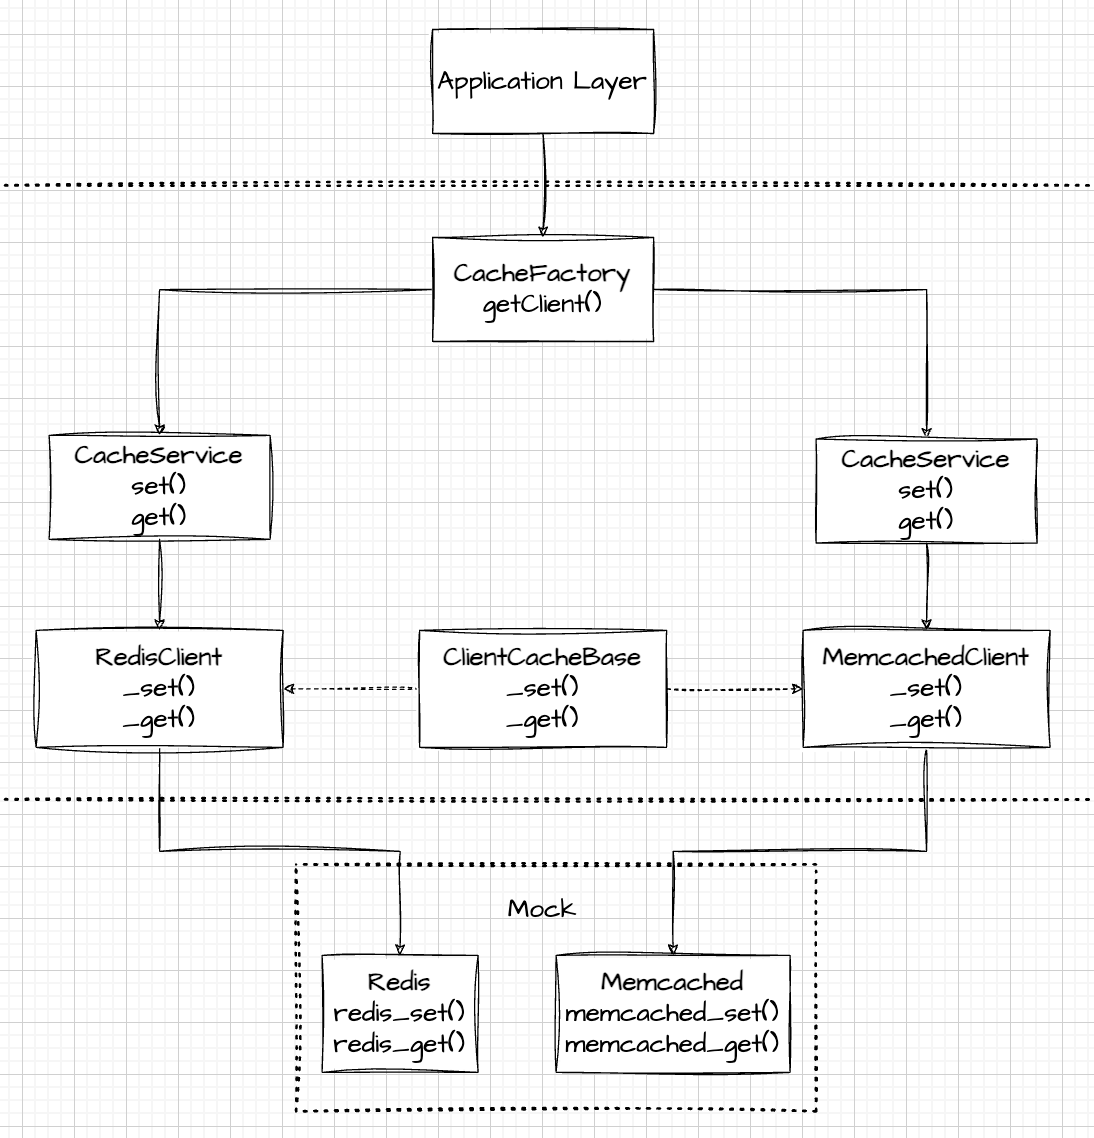

### Lời kết
Các patterns có thể dễ dàng kết hợp lại với nhau nếu bạn hiểu bản chất của nó, mỗi pattern đều có dấu hiệu nhận biết của chúng. Hãy tiếp tục theo dõi các bài viết tiếp theo của mình để làm chủ thêm nhiều patterns nữa nhé.